# Ship data analysis example

<img align="right" src="https://anitagraser.github.io/movingpandas/pics/movingpandas.png">

This tutorial uses AIS data published by the Danish Maritime Authority. The AIS record sample extracted for this tutorial covers vessel traffic on the 5th July 2017 near Gothenburg.

This tutorial covers: 
1. Trajectory data preprocessing
 1. Loading movement data from common geospatial file formats 
 1. Exploring spatial & non-spatial data distributions 
 1. Applying filters to extract relevant data
 1. Converting GeoDataFrames into Trajectories describing continuous tracks of moving objects
1. Trajectory analysis
 1. Visualizing trajectories and their properties
 1. Filtering trajectories by area of interest
 1. Splitting continuous tracks into individual trips
 1. Exploring trip properties including: origins, destinations, and attributes 

In [1]:
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import urllib
import os
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import movingpandas as mpd

import warnings
warnings.simplefilter("ignore")

## Loading sample AIS data 


In [4]:
%%time
df = read_file('../data/ais.gpkg')
wgs84 = df.crs
print("Finished reading {}".format(len(df)))

Finished reading 84702
Wall time: 3.84 s


Let's see what the data looks like:

In [5]:
df.head()

Timestamp       MMSI               NavStatus  SOG    COG  Name  \
0  05/07/2017 00:00:03  219632000  Under way using engine  0.0  270.4  None   
1  05/07/2017 00:00:05  265650970  Under way using engine  0.0    0.5  None   
2  05/07/2017 00:00:06  265503900  Under way using engine  0.0    0.0  None   
3  05/07/2017 00:00:14  219632000  Under way using engine  0.0  188.4  None   
4  05/07/2017 00:00:19  265519650  Under way using engine  0.0  357.2  None   

    ShipType                   geometry  
0  Undefined  POINT (11.85958 57.68817)  
1  Undefined  POINT (11.84175 57.66150)  
2  Undefined  POINT (11.90650 57.69077)  
3  Undefined  POINT (11.85958 57.68817)  
4  Undefined  POINT (11.87192 57.68233)

<AxesSubplot:>

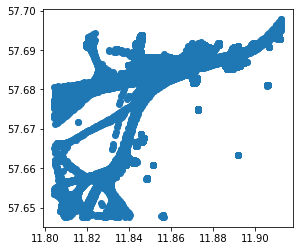

In [6]:
df.plot()

To convert the DataFrame to Trajectories we need to create a temporal index:

In [7]:
df['t'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
df = df.set_index('t')

If we look at the data distributions, we can see that there are a lot of records with speed over ground (SOG) values of zero in this dataframe:

<AxesSubplot:>

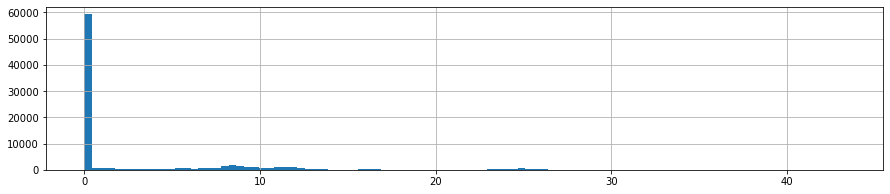

In [8]:
df['SOG'].hist(bins=100, figsize=(15,3))

Let's get rid of these rows with zero SOG:

Original size: 84702 rows
Reduced to 33593 rows after removing 0 speed records


<AxesSubplot:>

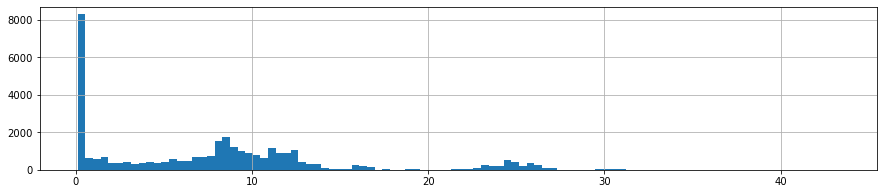

In [9]:
print("Original size: {} rows".format(len(df)))
df = df[df.SOG>0]
print("Reduced to {} rows after removing 0 speed records".format(len(df)))
df['SOG'].hist(bins=100, figsize=(15,3))

Let's see what kind of ships we have in our dataset:

<AxesSubplot:>

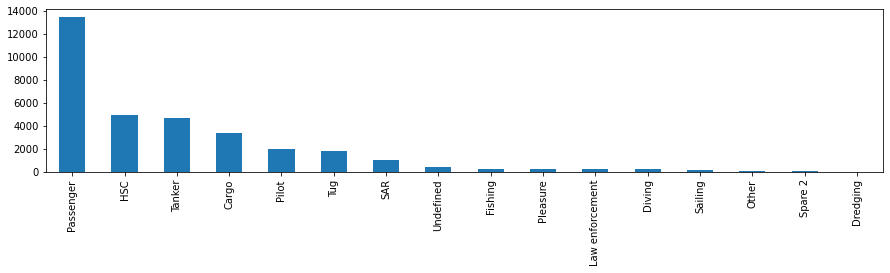

In [10]:
df['ShipType'].value_counts().plot(kind='bar', figsize=(15,3))

Finally, let's create trajectories:

In [11]:
%%time
MIN_LENGTH = 100 # meters
traj_collection = mpd.TrajectoryCollection(df, 'MMSI', min_length=MIN_LENGTH)
print("Finished creating {} trajectories".format(len(traj_collection)))

Finished creating 77 trajectories
Wall time: 4.8 s


In [12]:
traj_collection = mpd.MinTimeDeltaGeneralizer(traj_collection).generalize(tolerance=timedelta(minutes=1))

## Plotting trajectories

Let's give the most common ship types distinct colors. The remaining ones will be just grey:

<AxesSubplot:>

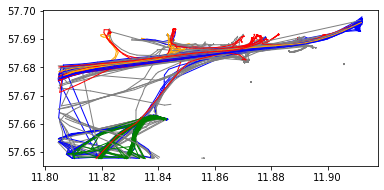

In [13]:
shiptype_to_color = {'Passenger': 'blue', 'HSC': 'green', 'Tanker': 'red', 'Cargo': 'orange'}
traj_collection.plot(column='ShipType', column_to_color=shiptype_to_color, linewidth=1, capstyle='round')

In [14]:
passenger = traj_collection.filter('ShipType', 'Passenger')
passenger.hvplot(title='Passenger ferries', line_width=2)

:Overlay
   .Tiles.I   :Tiles   [x,y]
   .Path.I    :Path   [Longitude,Latitude]
   .Path.II   :Path   [Longitude,Latitude]
   .Path.III  :Path   [Longitude,Latitude]
   .Path.IV   :Path   [Longitude,Latitude]
   .Path.V    :Path   [Longitude,Latitude]
   .Path.VI   :Path   [Longitude,Latitude]
   .Path.VII  :Path   [Longitude,Latitude]
   .Path.VIII :Path   [Longitude,Latitude]
   .Path.IX   :Path   [Longitude,Latitude]
   .Path.X    :Path   [Longitude,Latitude]
   .Path.XI   :Path   [Longitude,Latitude]
   .Path.XII  :Path   [Longitude,Latitude]
   .Path.XIII :Path   [Longitude,Latitude]
   .Path.XIV  :Path   [Longitude,Latitude]

## Visualizing trajectory properties

We can also plot individual trajectories to better visualize their properties, such as the changes in NavStatus:

In [15]:
my_traj = traj_collection.trajectories[0]
my_traj.df.head()

Timestamp       MMSI               NavStatus  \
t                                                                             
2017-07-05 17:32:18  05/07/2017 17:32:18  210035000  Under way using engine   
2017-07-05 17:33:18  05/07/2017 17:33:18  210035000  Under way using engine   
2017-07-05 17:34:18  05/07/2017 17:34:18  210035000  Under way using engine   
2017-07-05 17:35:28  05/07/2017 17:35:28  210035000  Under way using engine   
2017-07-05 17:36:28  05/07/2017 17:36:28  210035000  Under way using engine   

                     SOG   COG            Name ShipType  \
t                                                         
2017-07-05 17:32:18  9.8  52.8  NORDIC HAMBURG    Cargo   
2017-07-05 17:33:18  9.5  58.9  NORDIC HAMBURG    Cargo   
2017-07-05 17:34:18  9.3  70.5  NORDIC HAMBURG    Cargo   
2017-07-05 17:35:28  9.5  71.1  NORDIC HAMBURG    Cargo   
2017-07-05 17:36:28  9.4  71.3  NORDIC HAMBURG    Cargo   

                                      geometry  
t                                               
2017-07-05 17:32:18  POINT (11.80462 57.67612)  
2017-07-05 17:33:18  POINT (11.80875 57.67773)  
2017-07-05 17:34:18  POINT (11.81311 57.67879)  
2017-07-05 17:35:28  POINT (11.81855 57.67968)  
2017-07-05 17:36:28  POINT (11.82334 57.68044)

In [16]:
my_traj.df.tail()

Timestamp       MMSI NavStatus  SOG    COG  \
t                                                                           
2017-07-05 22:47:34  05/07/2017 22:47:34  210035000    Moored  0.1  276.0   
2017-07-05 23:08:44  05/07/2017 23:08:44  210035000    Moored  0.1   96.0   
2017-07-05 23:09:54  05/07/2017 23:09:54  210035000    Moored  0.1   96.0   
2017-07-05 23:11:45  05/07/2017 23:11:45  210035000    Moored  0.1   96.0   
2017-07-05 23:35:58  05/07/2017 23:35:58  210035000    Moored  0.1  276.0   

                               Name ShipType                   geometry  
t                                                                        
2017-07-05 22:47:34  NORDIC HAMBURG    Cargo  POINT (11.84571 57.68958)  
2017-07-05 23:08:44  NORDIC HAMBURG    Cargo  POINT (11.84571 57.68958)  
2017-07-05 23:09:54  NORDIC HAMBURG    Cargo  POINT (11.84571 57.68958)  
2017-07-05 23:11:45  NORDIC HAMBURG    Cargo  POINT (11.84571 57.68958)  
2017-07-05 23:35:58  NORDIC HAMBURG    Cargo  POINT (11.84571 57.68958)

In [17]:
my_traj.hvplot(title='Trajectory {}'.format(str(my_traj.id)), height=300, line_width=5.0, c='NavStatus', cmap='Dark2') 

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]   (NavStatus)

## Finding ships passing under Älvsborgsbron bridge
We can find ships passing under the bridge based on trajectory intersections with the bridge area.

In [18]:
area_of_interest = Polygon([(11.89935, 57.69270), (11.90161, 57.68902), (11.90334, 57.68967), (11.90104, 57.69354), (11.89935, 57.69270)])

In [19]:
intersecting = traj_collection.get_intersecting(area_of_interest)
print("Found {} intersections".format(len(intersecting)))

Found 20 intersections


In [20]:
bridge_traj = intersecting.trajectories[0]
bridge_traj.hvplot(title='Trajectory {}'.format(str(bridge_traj.id)), height=300, line_width=5.0, c='NavStatus', cmap='Dark2') 

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]   (NavStatus)

In [21]:
bridge_traj.df.head()

Timestamp       MMSI               NavStatus  \
t                                                                             
2017-07-05 01:21:57  05/07/2017 01:21:57  219011922  Under way using engine   
2017-07-05 01:23:06  05/07/2017 01:23:06  219011922  Under way using engine   
2017-07-05 01:24:06  05/07/2017 01:24:06  219011922  Under way using engine   
2017-07-05 01:25:06  05/07/2017 01:25:06  219011922  Under way using engine   
2017-07-05 01:26:08  05/07/2017 01:26:08  219011922  Under way using engine   

                     SOG    COG         Name ShipType  \
t                                                       
2017-07-05 01:21:57  8.8  227.7  SCANDINAVIA   Tanker   
2017-07-05 01:23:06  8.7  227.5  SCANDINAVIA   Tanker   
2017-07-05 01:24:06  8.7  227.0  SCANDINAVIA   Tanker   
2017-07-05 01:25:06  8.6  238.8  SCANDINAVIA   Tanker   
2017-07-05 01:26:08  8.5  245.4  SCANDINAVIA   Tanker   

                                      geometry  
t                                               
2017-07-05 01:21:57  POINT (11.91230 57.69633)  
2017-07-05 01:23:06  POINT (11.90842 57.69440)  
2017-07-05 01:24:06  POINT (11.90515 57.69275)  
2017-07-05 01:25:06  POINT (11.90161 57.69129)  
2017-07-05 01:26:08  POINT (11.89763 57.69015)

## Identifying trip origins and destinations

Since AIS records with a speed over ground (SOG) value of zero have been removed from the dataset, we can use the `split_by_observation_gap()` function to split the continuous observations into individual trips:

In [22]:
trips = mpd.ObservationGapSplitter(passenger).split(gap=timedelta(minutes=5))
print("Extracted {} individual trips from {} continuous vessel tracks".format(len(trips), len(passenger)))

Extracted 90 individual trips from 14 continuous vessel tracks


Let's plot the resulting trips!

In [23]:
trips.hvplot(title='Passenger ferry trips', line_width=2)

:Overlay
   .Tiles.I       :Tiles   [x,y]
   .Path.I        :Path   [Longitude,Latitude]
   .Path.II       :Path   [Longitude,Latitude]
   .Path.III      :Path   [Longitude,Latitude]
   .Path.IV       :Path   [Longitude,Latitude]
   .Path.V        :Path   [Longitude,Latitude]
   .Path.VI       :Path   [Longitude,Latitude]
   .Path.VII      :Path   [Longitude,Latitude]
   .Path.VIII     :Path   [Longitude,Latitude]
   .Path.IX       :Path   [Longitude,Latitude]
   .Path.X        :Path   [Longitude,Latitude]
   .Path.XI       :Path   [Longitude,Latitude]
   .Path.XII      :Path   [Longitude,Latitude]
   .Path.XIII     :Path   [Longitude,Latitude]
   .Path.XIV      :Path   [Longitude,Latitude]
   .Path.XV       :Path   [Longitude,Latitude]
   .Path.XVI      :Path   [Longitude,Latitude]
   .Path.XVII     :Path   [Longitude,Latitude]
   .Path.XVIII    :Path   [Longitude,Latitude]
   .Path.XIX      :Path   [Longitude,Latitude]
   .Path.XX       :Path   [Longitude,Latitude]
   .Path.XXI      :Path   [Longitude,Latitude]
   .Path.XXII     :Path   [Longitude,Latitude]
   .Path.XXIII    :Path   [Longitude,Latitude]
   .Path.XXIV     :Path   [Longitude,Latitude]
   .Path.XXV      :Path   [Longitude,Latitude]
   .Path.XXVI     :Path   [Longitude,Latitude]
   .Path.XXVII    :Path   [Longitude,Latitude]
   .Path.XXVIII   :Path   [Longitude,Latitude]
   .Path.XXIX     :Path   [Longitude,Latitude]
   .Path.XXX      :Path   [Longitude,Latitude]
   .Path.XXXI     :Path   [Longitude,Latitude]
   .Path.XXXII    :Path   [Longitude,Latitude]
   .Path.XXXIII   :Path   [Longitude,Latitude]
   .Path.XXXIV    :Path   [Longitude,Latitude]
   .Path.XXXV     :Path   [Longitude,Latitude]
   .Path.XXXVI    :Path   [Longitude,Latitude]
   .Path.XXXVII   :Path   [Longitude,Latitude]
   .Path.XXXVIII  :Path   [Longitude,Latitude]
   .Path.XXXIX    :Path   [Longitude,Latitude]
   .Path.XL       :Path   [Longitude,Latitude]
   .Path.XLI      :Path   [Longitude,Latitude]
   .Path.XLII     :Path   [Longitude,Latitude]
   .Path.XLIII    :Path   [Longitude,Latitude]
   .Path.XLIV     :Path   [Longitude,Latitude]
   .Path.XLV      :Path   [Longitude,Latitude]
   .Path.XLVI     :Path   [Longitude,Latitude]
   .Path.XLVII    :Path   [Longitude,Latitude]
   .Path.XLVIII   :Path   [Longitude,Latitude]
   .Path.XLIX     :Path   [Longitude,Latitude]
   .Path.L        :Path   [Longitude,Latitude]
   .Path.LI       :Path   [Longitude,Latitude]
   .Path.LII      :Path   [Longitude,Latitude]
   .Path.LIII     :Path   [Longitude,Latitude]
   .Path.LIV      :Path   [Longitude,Latitude]
   .Path.LV       :Path   [Longitude,Latitude]
   .Path.LVI      :Path   [Longitude,Latitude]
   .Path.LVII     :Path   [Longitude,Latitude]
   .Path.LVIII    :Path   [Longitude,Latitude]
   .Path.LIX      :Path   [Longitude,Latitude]
   .Path.LX       :Path   [Longitude,Latitude]
   .Path.LXI      :Path   [Longitude,Latitude]
   .Path.LXII     :Path   [Longitude,Latitude]
   .Path.LXIII    :Path   [Longitude,Latitude]
   .Path.LXIV     :Path   [Longitude,Latitude]
   .Path.LXV      :Path   [Longitude,Latitude]
   .Path.LXVI     :Path   [Longitude,Latitude]
   .Path.LXVII    :Path   [Longitude,Latitude]
   .Path.LXVIII   :Path   [Longitude,Latitude]
   .Path.LXIX     :Path   [Longitude,Latitude]
   .Path.LXX      :Path   [Longitude,Latitude]
   .Path.LXXI     :Path   [Longitude,Latitude]
   .Path.LXXII    :Path   [Longitude,Latitude]
   .Path.LXXIII   :Path   [Longitude,Latitude]
   .Path.LXXIV    :Path   [Longitude,Latitude]
   .Path.LXXV     :Path   [Longitude,Latitude]
   .Path.LXXVI    :Path   [Longitude,Latitude]
   .Path.LXXVII   :Path   [Longitude,Latitude]
   .Path.LXXVIII  :Path   [Longitude,Latitude]
   .Path.LXXIX    :Path   [Longitude,Latitude]
   .Path.LXXX     :Path   [Longitude,Latitude]
   .Path.LXXXI    :Path   [Longitude,Latitude]
   .Path.LXXXII   :Path   [Longitude,Latitude]
   .Path.LXXXIII  :Path   [Longitude,Latitude]
   .Path.LXXXIV   :Path   [Longitude,Latitude]
   .Path.L

Compared to plotting the original continuous observations, this visualization is much cleaner because there are no artifacts at the border of the area of interest. 

Next, let's get the trip origins:

In [24]:
origins = trips.get_start_locations()
origins.hvplot(title='Trip origins by ship type', c='Name', geo=True, tiles='OSM')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Name)

In our data sample, trip origins can be:
- When a ship departs its anchoring location and the speed changes from 0 to >0
- When a ship trajectory first enters the observation area

In [25]:
origins.hvplot(title='Origins by speed', c='SOG', geo=True, tiles='OSM')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (SOG)

## Finding ships that depart from Sjöfartsverket (Maritime Administration)

In [26]:
trips = mpd.ObservationGapSplitter(traj_collection).split(gap=timedelta(minutes=5))
area_of_interest = Polygon([(11.86815, 57.68273), (11.86992, 57.68047), (11.87419, 57.68140), (11.87288, 57.68348), (11.86815, 57.68273)])

We can identify vessels that start their trip within a given area of interest by intersecting trip starting locations with our area of interest:

In [27]:
departures = []
for traj in trips:
    if traj.get_start_location().intersects(area_of_interest) and traj.get_length() > 100:
        departures.append(traj)
print("Found {} departures".format(len(departures)))

Found 12 departures


In [28]:
departures[1].hvplot(title='Trajectory {}'.format(departures[1].id), line_width=5, c='Name', cmap='Dark2') 

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [Longitude,Latitude]   (Name)

Let's see what kind of ships depart from here:

In [29]:
for traj in departures:
    print("{} vessel '{}' departed at {}".format(traj.df['ShipType'].iloc[0], traj.df['Name'].iloc[0], traj.get_start_time()))

Law enforcement vessel 'KBV 010' departed at 2017-07-05 10:36:03
Law enforcement vessel 'KBV 010' departed at 2017-07-05 14:33:02
Law enforcement vessel 'KBV 048' departed at 2017-07-05 10:20:44
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 01:21:07
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 04:15:04
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 06:58:56
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 08:45:08
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 12:02:18
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 13:34:42
Pilot vessel 'PILOT 794 SE' departed at 2017-07-05 22:32:47
Pilot vessel 'PILOT 218 SE' departed at 2017-07-05 09:27:24
Pilot vessel 'PILOT 218 SE' departed at 2017-07-05 16:10:29


Of course, the same works for arrivals:

In [30]:
arrivals = []
for traj in trips:
    if traj.get_end_location().intersects(area_of_interest) and traj.get_length() > 100:
        arrivals.append(traj)
print("Found {} arrivals".format(len(arrivals)))

for traj in arrivals:
    print("{} vessel '{}' arrived at {}".format(traj.df['ShipType'].iloc[0], traj.df['Name'].iloc[0], traj.get_end_time()))

Found 12 arrivals
Law enforcement vessel 'KBV 010' arrived at 2017-07-05 10:51:03
Law enforcement vessel 'KBV 048' arrived at 2017-07-05 10:26:44
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 01:36:56
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 04:45:36
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 08:16:46
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 08:54:34
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 13:06:37
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 16:44:06
Pilot vessel 'PILOT 794 SE' arrived at 2017-07-05 23:58:49
Pilot vessel 'PILOT 218 SE' arrived at 2017-07-05 10:07:23
Pilot vessel 'PILOT 218 SE' arrived at 2017-07-05 17:46:12
Tanker vessel 'DANA' arrived at 2017-07-05 08:35:42


## Clustering origins

To run this section, you need to have the scikit-learn package installed. 

In [31]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [32]:
origins = trips.get_start_locations()
origins['lat'] = origins.geometry.y
origins['lon'] = origins.geometry.x
matrix = origins[['lat','lon']].values

In [33]:
kms_per_radian = 6371.0088
epsilon = 0.1 / kms_per_radian

In [34]:
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(matrix))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([matrix[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 69


In [35]:
origins['cluster'] = cluster_labels

In [36]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return Point(tuple(centermost_point)[1], tuple(centermost_point)[0])
centermost_points = clusters.map(get_centermost_point)

In [37]:
origins.hvplot(title='Clustered origins', c='cluster', geo=True, tiles='OSM', cmap='glasbey_dark')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (cluster)

In [38]:
origins_by_cluster = pd.DataFrame(origins).groupby(['cluster'])
summary = origins_by_cluster['ShipType'].unique().to_frame(name='types')
summary['n'] = origins_by_cluster.size()
summary['symbol_size'] = summary['n']*10 # for visualization purposes
summary['sog'] = origins_by_cluster['SOG'].mean()
summary['geometry'] = centermost_points
summary = summary[summary['n']>1].sort_values(by='n', ascending=False)
summary.head()

types   n  symbol_size  \
cluster                                                                    
5        [Tanker, Passenger, Undefined, Fishing, Cargo]  52          520   
28                          [Passenger, Undefined, HSC]  47          470   
0                       [Cargo, Tanker, Tug, Passenger]  28          280   
27                          [Passenger, Undefined, HSC]  24          240   
11                                     [SAR, Passenger]  19          190   

               sog                     geometry  
cluster                                          
5         9.217308   POINT (11.911787 57.69663)  
28        0.804255   POINT (11.84232 57.661593)  
0        11.946429   POINT (11.80495 57.676108)  
27       15.987500  POINT (11.819332 57.648027)  
11       10.736842  POINT (11.804653 57.654408)

In [39]:
cluster_of_interest_id = 28
origins[origins['cluster']==cluster_of_interest_id].hvplot(
    title='Cluster {}'.format(cluster_of_interest_id), c='ShipType', geo=True, tiles='OSM', height=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (ShipType)

In [40]:
( trips.hvplot(title='Origin clusters by speed', color='gray', line_width=1) *
  GeoDataFrame(summary, crs=wgs84).hvplot(c='sog', size='symbol_size', geo=True,  cmap='RdYlGn')
)

:Overlay
   .Tiles.I         :Tiles   [x,y]
   .Path.I          :Path   [Longitude,Latitude]
   .Path.II         :Path   [Longitude,Latitude]
   .Path.III        :Path   [Longitude,Latitude]
   .Path.IV         :Path   [Longitude,Latitude]
   .Path.V          :Path   [Longitude,Latitude]
   .Path.VI         :Path   [Longitude,Latitude]
   .Path.VII        :Path   [Longitude,Latitude]
   .Path.VIII       :Path   [Longitude,Latitude]
   .Path.IX         :Path   [Longitude,Latitude]
   .Path.X          :Path   [Longitude,Latitude]
   .Path.XI         :Path   [Longitude,Latitude]
   .Path.XII        :Path   [Longitude,Latitude]
   .Path.XIII       :Path   [Longitude,Latitude]
   .Path.XIV        :Path   [Longitude,Latitude]
   .Path.XV         :Path   [Longitude,Latitude]
   .Path.XVI        :Path   [Longitude,Latitude]
   .Path.XVII       :Path   [Longitude,Latitude]
   .Path.XVIII      :Path   [Longitude,Latitude]
   .Path.XIX        :Path   [Longitude,Latitude]
   .Path.XX         :Path   [Longitude,Latitude]
   .Path.XXI        :Path   [Longitude,Latitude]
   .Path.XXII       :Path   [Longitude,Latitude]
   .Path.XXIII      :Path   [Longitude,Latitude]
   .Path.XXIV       :Path   [Longitude,Latitude]
   .Path.XXV        :Path   [Longitude,Latitude]
   .Path.XXVI       :Path   [Longitude,Latitude]
   .Path.XXVII      :Path   [Longitude,Latitude]
   .Path.XXVIII     :Path   [Longitude,Latitude]
   .Path.XXIX       :Path   [Longitude,Latitude]
   .Path.XXX        :Path   [Longitude,Latitude]
   .Path.XXXI       :Path   [Longitude,Latitude]
   .Path.XXXII      :Path   [Longitude,Latitude]
   .Path.XXXIII     :Path   [Longitude,Latitude]
   .Path.XXXIV      :Path   [Longitude,Latitude]
   .Path.XXXV       :Path   [Longitude,Latitude]
   .Path.XXXVI      :Path   [Longitude,Latitude]
   .Path.XXXVII     :Path   [Longitude,Latitude]
   .Path.XXXVIII    :Path   [Longitude,Latitude]
   .Path.XXXIX      :Path   [Longitude,Latitude]
   .Path.XL         :Path   [Longitude,Latitude]
   .Path.XLI        :Path   [Longitude,Latitude]
   .Path.XLII       :Path   [Longitude,Latitude]
   .Path.XLIII      :Path   [Longitude,Latitude]
   .Path.XLIV       :Path   [Longitude,Latitude]
   .Path.XLV        :Path   [Longitude,Latitude]
   .Path.XLVI       :Path   [Longitude,Latitude]
   .Path.XLVII      :Path   [Longitude,Latitude]
   .Path.XLVIII     :Path   [Longitude,Latitude]
   .Path.XLIX       :Path   [Longitude,Latitude]
   .Path.L          :Path   [Longitude,Latitude]
   .Path.LI         :Path   [Longitude,Latitude]
   .Path.LII        :Path   [Longitude,Latitude]
   .Path.LIII       :Path   [Longitude,Latitude]
   .Path.LIV        :Path   [Longitude,Latitude]
   .Path.LV         :Path   [Longitude,Latitude]
   .Path.LVI        :Path   [Longitude,Latitude]
   .Path.LVII       :Path   [Longitude,Latitude]
   .Path.LVIII      :Path   [Longitude,Latitude]
   .Path.LIX        :Path   [Longitude,Latitude]
   .Path.LX         :Path   [Longitude,Latitude]
   .Path.LXI        :Path   [Longitude,Latitude]
   .Path.LXII       :Path   [Longitude,Latitude]
   .Path.LXIII      :Path   [Longitude,Latitude]
   .Path.LXIV       :Path   [Longitude,Latitude]
   .Path.LXV        :Path   [Longitude,Latitude]
   .Path.LXVI       :Path   [Longitude,Latitude]
   .Path.LXVII      :Path   [Longitude,Latitude]
   .Path.LXVIII     :Path   [Longitude,Latitude]
   .Path.LXIX       :Path   [Longitude,Latitude]
   .Path.LXX        :Path   [Longitude,Latitude]
   .Path.LXXI       :Path   [Longitude,Latitude]
   .Path.LXXII      :Path   [Longitude,Latitude]
   .Path.LXXIII     :Path   [Longitude,Latitude]
   .Path.LXXIV      :Path   [Longitude,Latitude]
   .Path.LXXV       :Path   [Longitude,Latitude]
   .Path.LXXVI      :Path   [Longitude,Latitude]
   .Path.LXXVII     :Path   [Longitude,Latitude]
   .Path.LXXVIII    :Path   [Longitude,Latitude]
   .Path.LXXIX      :Path   [Longitude,Latitude]
   .Path.LXXX       :Path   [Longitude,Latitude]
   .Path.LXXXI      :Path   [Longitu

## Continue exploring MovingPandas


1. [Ship data analysis](2-ship-data.ipynb)
2. [Bird migration analysis](1-bird-migration.ipynb)
3. [Horse collar data exploration](3-horse-collar.ipynb)
4. [Stop hotspot detection](4-stop-hotspots.ipynb)